<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-a-maze" data-toc-modified-id="Create-a-maze-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create a maze</a></span><ul class="toc-item"><li><span><a href="#Randomized-Prim's-algorithm" data-toc-modified-id="Randomized-Prim's-algorithm-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Randomized Prim's algorithm</a></span></li><li><span><a href="#Completely-random-maze" data-toc-modified-id="Completely-random-maze-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Completely random maze</a></span></li></ul></li><li><span><a href="#Special-mazes" data-toc-modified-id="Special-mazes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Special mazes</a></span><ul class="toc-item"><li><span><a href="#One-minimum" data-toc-modified-id="One-minimum-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>One minimum</a></span></li><li><span><a href="#Two-minima" data-toc-modified-id="Two-minima-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Two minima</a></span></li></ul></li><li><span><a href="#Binary-maze-to-energy-interpolation" data-toc-modified-id="Binary-maze-to-energy-interpolation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Binary maze to energy interpolation</a></span></li><li><span><a href="#Lennard-Jones-mazes" data-toc-modified-id="Lennard-Jones-mazes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Lennard-Jones mazes</a></span></li><li><span><a href="#Reference-simulations" data-toc-modified-id="Reference-simulations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Reference simulations</a></span><ul class="toc-item"><li><span><a href="#One-minimum" data-toc-modified-id="One-minimum-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>One minimum</a></span><ul class="toc-item"><li><span><a href="#Euler-(NVE)" data-toc-modified-id="Euler-(NVE)-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Euler (<em>NVE</em>)</a></span></li><li><span><a href="#Euler-Maruyama-(NVT)" data-toc-modified-id="Euler-Maruyama-(NVT)-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Euler-Maruyama (<em>NVT</em>)</a></span></li></ul></li><li><span><a href="#Two-minima" data-toc-modified-id="Two-minima-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Two minima</a></span><ul class="toc-item"><li><span><a href="#Euler-Maruyama-(NVT)" data-toc-modified-id="Euler-Maruyama-(NVT)-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Euler-Maruyama (<em>NVT</em>)</a></span></li></ul></li></ul></li><li><span><a href="#Construct-adjacency-matrix" data-toc-modified-id="Construct-adjacency-matrix-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Construct adjacency matrix</a></span><ul class="toc-item"><li><span><a href="#Dijkstra" data-toc-modified-id="Dijkstra-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Dijkstra</a></span></li></ul></li><li><span><a href="#Scratch" data-toc-modified-id="Scratch-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Scratch</a></span></li></ul></div>

# SqRA on relevant subspaces

Construction of adjacency matrices from potential energy surfaces by maze exploration algorithms, SqRA and comparison to MD/MSM.

In [1]:
from abc import ABC, abstractmethod
from collections import deque
import heapq
import random

import eski.atoms
import eski.drivers
import eski.interactions
import eski.md
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx
import numpy as np
import scipy.interpolate

In [2]:
%load_ext Cython

In [3]:
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams['animation.html'] = 'html5'

In [4]:
# Version information
print("Python: ", *sys.version.split("\n"))

print("Packages:")
for package in [mpl, networkx, np]:
    print(f"    {package.__name__}: {package.__version__}")

Python:  3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27)  [GCC 9.3.0]
Packages:
    matplotlib: 3.4.1
    networkx: 2.3
    numpy: 1.20.2


## Create a maze

A maze acts here as a proxy for a *n*-dimensional energy function `f(*args) -> E`.

Mazes as NumPy ndarrays are composed of cells which are either 0 (wall/high energy/inaccessible) or 1 (passage/low energy/accessible). Indexing into the array, simulates an energy calculation for a given state in the state space. A maze like this has no entrance or exit and can have periodic boundaries.

A smooth potential energy surface can be constructed through interpolation of the maze values.

### Randomized Prim's algorithm

Ensures the creation of a random contiguous maze with short dead ends.

Layout of the algorithm (grow the maze outward through random frontier cells):

  - Start with a maze of unassigned cells
  - Pick a starting cell and mark it as part of the maze
  - Mark the neighbouring cells of the starting cell as walls and add them to the list of walls (frontier)
  - As long as there are walls in the wall list:
     - Take a random wall out of the list
     - If the wall has an unassigned cell on the opposite side of a maze cell:
        - Turn the wall into a part of the maze
        - Mark the unassigned cell as part of the maze
        - Mark the unassigned neighbouring cells of the two assigned cells as walls and add them to the list of walls

In [15]:
class Maze:
    """Represents a maze

    Uses a pre-generated maze as (binary) proxy for
    potential energy calculations or serves as a basis
    to construct a smooth potential.

    Args:
        maze (optional): An *n*-dimensional maze (:class:`numpy.ndarray`).
    """

    KW_MAKE_MAP = {
        "prim": "_make_maze_prim",
    }

    def __init__(self, maze=None):
        self.maze = maze

    def __repr__(self):
        return f"{type(self).__name__}()"

    def __str__(self):
        if self.maze is None:
            return []

        return str(self.maze)

    def _check_algorithm(self, algorithm):
        try:
            make_func = self.__getattribute__(self.KW_MAKE_MAP.get(algorithm, algorithm))
        except AttributeError:
            raise ValueError(
                    f"Invalid algorithm {algorithm}. "
                    f"Must be one of {list(self.KW_MAKE_MAP.keys())}"
                    )
        return make_func

    def make(self, algorithm="prim", size=None):
        make_func = self._check_algorithm(algorithm)
        self.maze = next(make_func(size=size))

    def make_animate_2d(
            self,
            algorithm="prim",
            size=None,
            interval=1,
            imshow_props=None,
            animate_props=None,
            ax=None, ax_props=None):

        if len(size) != 2:
            raise ValueError("Can only animate two dimensional mazes.")

        make_func = self._check_algorithm(algorithm)

        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.get_figure()

        default_imshow_props = {
            "vmin": -1,
            "vmax": 1,
            "cmap": mpl.cm.inferno
        }
        if imshow_props is not None:
            default_imshow_props.update(imshow_props)

        default_animate_props = {
            "blit": True,
            "interval": 50,
            "repeat": False,
            "save_count": np.prod(size)
        }
        if animate_props is not None:
            default_animate_props.update(animate_props)

        default_ax_props = {
            "xticks": (),
            "yticks": (),
        }
        if ax_props is not None:
            default_ax_props.update(ax_props)

        maze_states = make_func(size=size, interval=interval)
        im = ax.imshow(next(maze_states), **default_imshow_props)

        ax.set(**default_ax_props)

        def init():
            im.set_data(next(maze_states))
            return im,

        def update(i):
            im.set_array(i)
            return im,

        animation = mpl.animation.FuncAnimation(
            fig, update, init_func=init,
            frames=maze_states, **default_animate_props
            )

        # self.maze = im.get_array()

        return animation

    def _make_maze_prim(self, size=None, interval=None):
        """Create a maze using a variation of the randomized Prim's algorithm

        Uses periodic boundaries in all dimensions.

        Cells have values corresponding to

          * wall: 1
          * passage: 0
          * unassigned: -1

        Note:
           This gives a maze on a multi-dimensional grid in which
           a cell can either be a wall (inaccessible) or part of
           the maze (accessible). All neighbouring accessible cells
           are connected. The maze is *not* a minimal spanning tree
           over all cells!

           This kind of maze is different to for example a maze on
           a graph in which all cells (nodes) are part of the maze
           and connected by either a passage or a wall (edges).

        Keyword args:
            size (tuple of integers): Shape of the created maze.
            interval: If not `None`, yields the state in intervals
                of this many creation steps.

        Returns:
           Maze as numpy.ndarray
        """

        def get_neighbouring_cell_pairs(cell):
            for i, coordinate in enumerate(cell):
                yield (
                    (*cell[:i], (cell[i] + 1) % size[i], *cell[i + 1:]),
                    (*cell[:i], (cell[i] - 1) % size[i], *cell[i + 1:])
                    )

        def get_neighbouring_cells(cell, condition=None):
            for i, coordinate in enumerate(cell):
                for neighbour_coordinate in [
                        (cell[i] + 1) % size[i],
                        (cell[i] - 1) % size[i]]:

                    neighbour_cell = (*cell[:i], neighbour_coordinate, *cell[i + 1:])
                    if (condition is None) | (maze[neighbour_cell] == condition):
                        yield neighbour_cell

        def make_wall(cell):
            maze[cell] = 1
            wall_list.append(cell)

        def grow(cell, next_cell):
            maze[cell] = 0
            maze[next_cell] = 0
            for neighbour in get_neighbouring_cells(next_cell, condition=-1):
                make_wall(neighbour)

        if size is None:
            size = (2, 2)

        maze = np.full(size, -1, dtype=int)

        if interval is not None:
            yield maze

        wall_list = []

        cell = tuple(np.random.randint(0, s) for s in size)
        maze[cell] = 0

        for neighbour in get_neighbouring_cells(cell):
            make_wall(neighbour)

        if interval is not None:
            yield maze

        n_steps = 1
        while wall_list:
            random.shuffle(wall_list)
            cell = wall_list.pop()

            for cell_a, cell_b in get_neighbouring_cell_pairs(cell):
                state_a, state_b = (
                    maze[c] for c in [cell_a, cell_b]
                    )

                if (state_a == -1) & (state_b == 0):
                    grow(cell, cell_a)
                    break

                elif (state_b == -1) & (state_a == 0):
                    grow(cell, cell_b)
                    break

            for neighbour in get_neighbouring_cells(cell, condition=-1):
                make_wall(neighbour)

            if (interval is not None) and (n_steps % interval == 0):
                yield maze
            n_steps += 1

        if (interval is None) or (n_steps % interval != 0):
            yield maze

    def enclose_maze(self, wall_height=5):
        walled_maze = np.full(
            tuple(x + 2 for x in self.maze.shape), wall_height, dtype=float
            )
        s = slice(1, -1)
        walled_maze[tuple(s for _ in range(maze.maze.ndim))] = self.maze
        self.maze = walled_maze

    def pick_first_accessible_cell(self):
        if self.maze is None:
            return

        for cell in np.ndindex(self.maze.shape):
            if self.maze[cell] == 0:
                return cell

    def pick_random_accessible_cell(self):
        if self.maze is None:
            return

        while True:
            cell = tuple(np.random.randint(0, s) for s in self.maze.shape)
            if self.maze[cell] == 0:
                return cell
            
    def interpolate_bisplrep(self, *args, **kwargs):
        if self.maze.ndim != 2:
            raise ValueError("Can only interpolate 2D maze using this function")

        xmax, ymax = maze.maze.shape
        X, Y = np.mgrid[0:xmax-1:complex(xmax), 0:ymax-1:complex(ymax)]
    
        return scipy.interpolate.bisplrep(X, Y, maze.maze, s=0)
    
    def plot2d(self, ax=None, imshow_props=None, ax_props=None):
        if self.maze is None:
            return
        
        if self.maze.ndim != 2:
            raise ValueError("Can only visualize 2D maze with this function")
            
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.get_figure()

        default_imshow_props = {
            "vmin": -1,
            "vmax": 1,
            "cmap": mpl.cm.inferno,
            "extent": [0, self.maze.shape[1] - 1, 0, self.maze.shape[0] - 1]
        }
        if imshow_props is not None:
            default_imshow_props.update(imshow_props)
            
        default_ax_props = {
            "xticks": (),
            "yticks": (),
        }
        if ax_props is not None:
            default_ax_props.update(ax_props)
            
        im = ax.imshow(
            self.maze, **default_imshow_props
            )
        
        ax.set(**default_ax_props)
        
        return im

In [6]:
random.seed(10)

In [7]:
maze = Maze()
maze

Maze()

In [106]:
maze.make(size=(20, 20))
print(maze)

[[1 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1]
 [0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 1 0]
 [1 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1]
 [0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0]
 [0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 0 1]
 [0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 1]
 [0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1]
 [0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 1]
 [1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0]
 [1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1]
 [1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1]
 [1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0]
 [1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1]
 [0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0]
 [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
 [0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0]]


In [109]:
# Dump maze
# np.save("data/example_maze2D_20_20.npy", maze.maze)

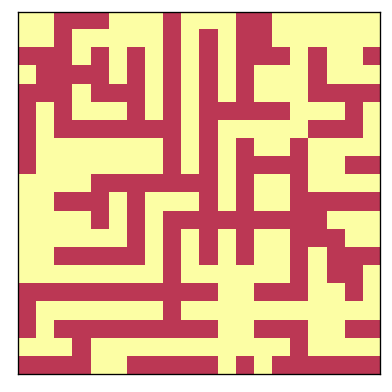

In [108]:
maze.plot2d()

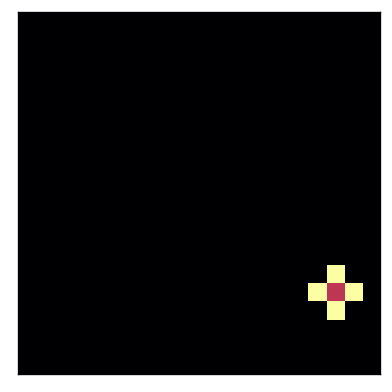

In [110]:
animation = maze.make_animate_2d(size=(20, 20))

In [111]:
animation

In [112]:
cell = maze.pick_random_accessible_cell()
cell

(7, 8)

### Completely random maze

Not ideal. It is very probable that the maze has more than one connected component.

In [121]:
rng = np.random.default_rng(11)
maze = Maze(rng.integers(0, 2, size=(10, 10)))

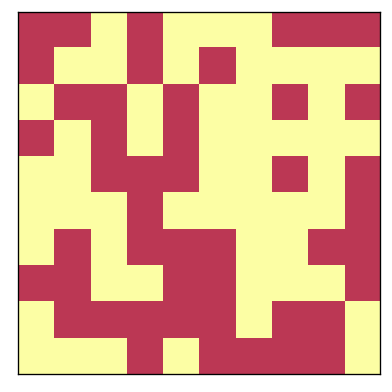

In [124]:
maze.plot2d()

## Special mazes

### One minimum

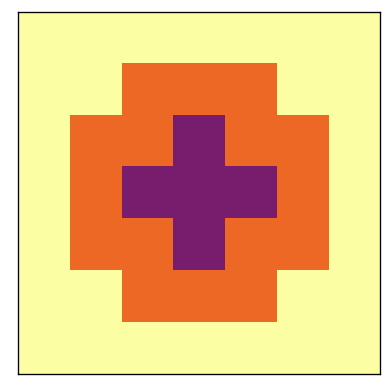

In [136]:
one_minimum_maze = Maze(
    np.array([
        [2, 2, 2, 2, 2, 2, 2],
        [2, 2, 1, 1, 1, 2, 2],
        [2, 1, 1, 0, 1, 1, 2],
        [2, 1, 0, 0, 0, 1, 2],
        [2, 1, 1, 0, 1, 1, 2],
        [2, 2, 1, 1, 1, 2, 2],
        [2, 2, 2, 2, 2, 2, 2],
    ])
)

one_minimum_maze.plot2d(
    imshow_props={"vmax": 2}
)

In [137]:
np.save("data/one_minimum.npy", one_minimum_maze.maze)

### Two minima

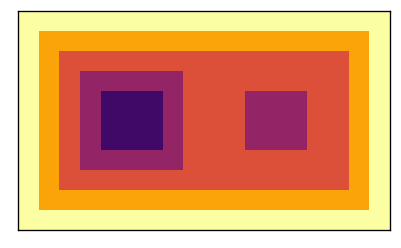

In [68]:
two_minima_maze = Maze(
    np.array([
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4],
        [4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4],
        [4, 3, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4],
        [4, 3, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 1, 2, 2, 3, 4],
        [4, 3, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 1, 2, 2, 3, 4],
        [4, 3, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 1, 2, 2, 3, 4],
        [4, 3, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4],
        [4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4],
        [4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    ])
)

fig, ax = plt.subplots(figsize=(4, 8))
two_minima_maze.plot2d(
    ax=ax,
    imshow_props={"vmax": 4},
)

In [69]:
np.save("data/two_minima.npy", two_minima_maze.maze)

## Binary maze to energy interpolation 

Below we define a new custom interaction to be used by Eski. Most important is the implementation of the `add_force_by_index` method a

In [70]:
%%cython

import scipy
import eski.interactions
cimport eski.md
from eski.primitive_types cimport AINDEX, AVALUE


class ExternalBisplev2D(eski.interactions.CustomInteraction):
    """External potential from 2D

    This interaction does not accept any parameters but requires
    an interpolation `tck` tuple obtained from `scipy.interpolate.bisplrep`.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.tck = kwargs["tck"]

    def add_force_by_index(
            self, index, eski.md.System system):
        """Evaluate position dependend external force

        Args:
            index: Index of interaction
            system: :class:`eski.md.System`
        """

        cdef AINDEX pi = self._indices[index * self._dindex]

        x, y = system._configuration[pi:pi + 2]
        
        system._forces[pi] -= scipy.interpolate.bisplev(x, y, self.tck, dx=1)
        system._forces[pi + 1] -= scipy.interpolate.bisplev(x, y, self.tck, dy=1)
        
    def get_energy_by_index(
            self, index, eski.md.System system):
        """Evaluate position dependend energy

        Args:
            index: Index of interaction
            system: :class:`eski.md.System`
        """

        cdef AINDEX pi = self._indices[index * self._dindex]

        x, y = system._configuration[pi:pi + 2]
        
        return scipy.interpolate.bisplev(x, y, self.tck)

## Lennard-Jones mazes

In [ ]:
configuration =

## Reference simulations

### One minimum

In [34]:
# Restore maze
maze = Maze()
maze.maze = np.load("data/one_minimum.npy")
tck = maze.interpolate_bisplrep()
external_potential = ExternalBisplev2D([0], [], tck=tck)

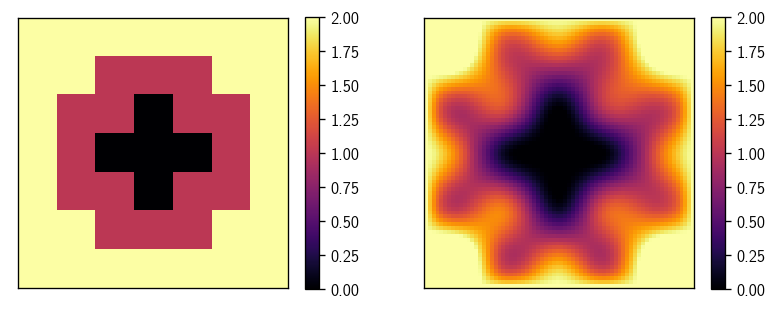

In [28]:
xmax, ymax = maze.maze.shape
wall_max = 2

factor = 10
xnew = np.linspace(0, xmax-1, xmax * factor)
ynew = np.linspace(0, ymax-1, ymax * factor)

plt.close("all")
fig, (oax, iax) = plt.subplots(1, 2, figsize=(8, 3))
oim = maze.plot2d(ax=oax, imshow_props={"vmin": 0, "vmax": wall_max})

iim = iax.imshow(
    scipy.interpolate.bisplev(xnew, ynew, tck),
    vmin=0, vmax=wall_max,
    cmap=mpl.cm.inferno
)

iax.set(**{
    "xticks": (),
    "yticks": (),
})
    
fig.colorbar(oim, ax=oax)
fig.colorbar(iim, ax=iax)
plt.show()

#### Euler (*NVE*)

In [29]:
cell = maze.pick_random_accessible_cell()
cell

(2, 3)

In [30]:
system = eski.md.System(
    np.array(np.array(cell), dtype=float),
    dim_per_atom=2,
    velocities=np.array([0, -0.5], dtype=float),
    atoms=[eski.atoms.Atom("X", mass=1)],
    custom_interactions=[external_potential],
    drivers=[eski.drivers.EulerIntegrator([1e-6])],
    reporters=[eski.md.ListReporter(100000), eski.md.PrintReporter(100000)],
    copy=True
)

In [31]:
system.simulate(int(1e6))
system.configuration

array([2.22186632, 2.7121758 ])

In [32]:
trajectory = np.vstack([x["configuration"] for x in system.reporters[0].output])

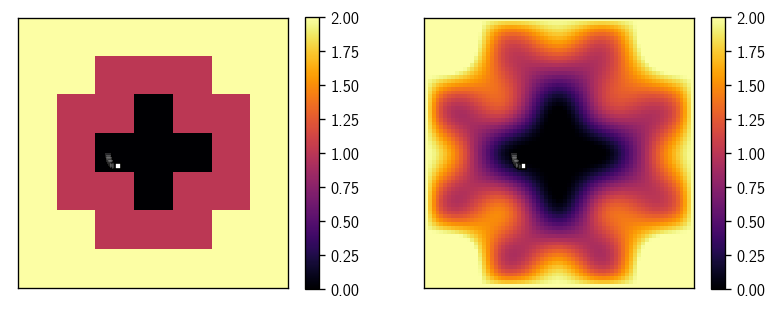

In [33]:
factor = 10
xnew = np.linspace(0, xmax-1, xmax * factor)
ynew = np.linspace(0, ymax-1, ymax * factor)

xmax, ymax = maze.maze.shape
wall_max = 2

factor = 10
xnew = np.linspace(0, xmax-1, xmax * factor)
ynew = np.linspace(0, ymax-1, ymax * factor)

plt.close("all")
fig, (oax, iax) = plt.subplots(1, 2, figsize=(8, 3))
oim = maze.plot2d(ax=oax, imshow_props={"vmin": 0, "vmax": wall_max})

iim = iax.imshow(
    scipy.interpolate.bisplev(xnew, ynew, tck),
    vmin=0, vmax=wall_max,
    cmap=mpl.cm.inferno, extent=[0, ymax - 1, 0, xmax - 1]
)

for ax in (oax, iax):
    ax.scatter(
        trajectory[:, 0], trajectory[:, 1],
        marker="s", facecolors="w", edgecolors="k",
        s=10, alpha=np.linspace(0.2, 1, trajectory.shape[0])
    )    

iax.set(**{
    "xticks": (),
    "yticks": (),
})
    
fig.colorbar(oim, ax=oax)
fig.colorbar(iim, ax=iax)
plt.show()

#### Euler-Maruyama (*NVT*)

In [35]:
cell = maze.pick_random_accessible_cell()
cell

(4, 3)

In [36]:
system = eski.md.System(
    np.array(np.array(cell), dtype=float),
    dim_per_atom=2,
    velocities=np.array([0, 0], dtype=float),
    atoms=[eski.atoms.Atom("X", mass=1)],
    custom_interactions=[external_potential],
    drivers=[eski.drivers.EulerMaruyamaIntegrator([1e-3, 100, 10])],
    reporters=[eski.md.ListReporter(100000), eski.md.PrintReporter(100000)]
)

In [37]:
system.simulate(int(1e7))
system.configuration

array([2.37868424, 3.02122597])

In [38]:
system.forces

array([-0.01946627, -0.09602897])

In [39]:
trajectory = np.vstack([x["configuration"] for x in system.reporters[0].output])

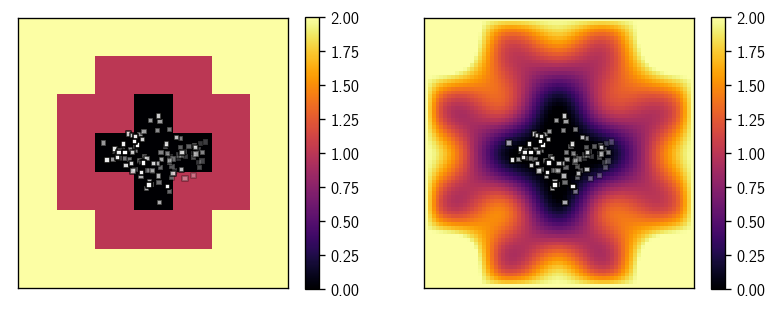

In [40]:
xmax, ymax = maze.maze.shape
wall_max = 2

factor = 10
xnew = np.linspace(0, xmax-1, xmax * factor)
ynew = np.linspace(0, ymax-1, ymax * factor)

plt.close("all")
fig, (oax, iax) = plt.subplots(1, 2, figsize=(8, 3))
oim = maze.plot2d(ax=oax, imshow_props={"vmin": 0, "vmax": wall_max})

iim = iax.imshow(
    scipy.interpolate.bisplev(xnew, ynew, tck),
    vmin=0, vmax=wall_max,
    cmap=mpl.cm.inferno,
    extent=[0, ymax - 1, 0, xmax - 1]
)

for ax in (oax, iax):
    ax.scatter(
        trajectory[:, 0], trajectory[:, 1],
        marker="s", facecolors="w", edgecolors="k",
        s=10, alpha=np.linspace(0.2, 1, trajectory.shape[0])
    )    

iax.set(**{
    "xticks": (),
    "yticks": (),
})
    
fig.colorbar(oim, ax=oax)
fig.colorbar(iim, ax=iax)
plt.show()

### Two minima

In [76]:
# Restore maze
maze = Maze()
maze.maze = np.load("data/two_minima.npy")
tck = maze.interpolate_bisplrep(s=0)
external_potential = ExternalBisplev2D([0], [], tck=tck)

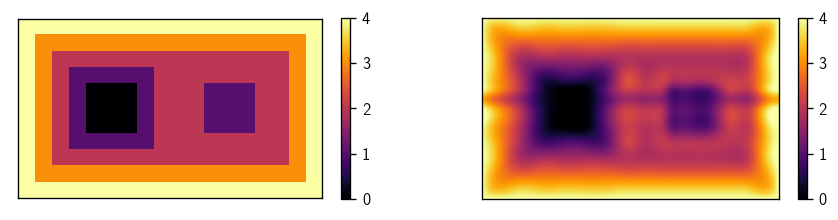

In [77]:
xmax, ymax = maze.maze.shape
wall_max = 4

factor = 10
xnew = np.linspace(0, xmax-1, xmax * factor)
ynew = np.linspace(0, ymax-1, ymax * factor)

plt.close("all")
fig, (oax, iax) = plt.subplots(1, 2, figsize=(9, 2))
oim = maze.plot2d(ax=oax, imshow_props={"vmin": 0, "vmax": wall_max})

iim = iax.imshow(
    scipy.interpolate.bisplev(xnew, ynew, tck),
    vmin=0, vmax=wall_max,
    cmap=mpl.cm.inferno
)

iax.set(**{
    "xticks": (),
    "yticks": (),
})
    
fig.colorbar(oim, ax=oax)
fig.colorbar(iim, ax=iax)
plt.show()

#### Euler-Maruyama (*NVT*)

In [86]:
cell = (3, 2)

In [87]:
system = eski.md.System(
    np.array(np.array(cell), dtype=float),
    dim_per_atom=2,
    velocities=np.array([0, 0], dtype=float),
    atoms=[eski.atoms.Atom("X", mass=1)],
    custom_interactions=[external_potential],
    drivers=[eski.drivers.EulerMaruyamaIntegrator([1e-3, 100, 20])],
    reporters=[eski.md.ListReporter(100000), eski.md.PrintReporter(100000)]
)

In [ ]:
system.simulate(int(2e7))
system.configuration

In [ ]:
system.forces

In [ ]:
trajectory = np.vstack([x["configuration"] for x in system.reporters[0].output])

In [ ]:
xmax, ymax = maze.maze.shape
wall_max = 4

factor = 10
xnew = np.linspace(0, xmax-1, xmax * factor)
ynew = np.linspace(0, ymax-1, ymax * factor)

plt.close("all")
fig, (oax, iax) = plt.subplots(1, 2, figsize=(9, 2))
oim = maze.plot2d(ax=oax, imshow_props={"vmin": 0, "vmax": wall_max})

iim = iax.imshow(
    scipy.interpolate.bisplev(xnew, ynew, tck),
    vmin=0, vmax=wall_max,
    cmap=mpl.cm.inferno,
    extent=[0, ymax - 1, 0, xmax - 1]
)

for ax in (oax, iax):
    ax.scatter(
        trajectory[:, 0], trajectory[:, 1],
        marker="s", facecolors="w", edgecolors="k",
        s=10, alpha=np.linspace(0.2, 1, trajectory.shape[0])
    )    

iax.set(**{
    "xticks": (),
    "yticks": (),
})
    
fig.colorbar(oim, ax=oax)
fig.colorbar(iim, ax=iax)
plt.show()

## Construct adjacency matrix

Given an energy function (a maze), pick an accessible starting state and explore the respective connected component using graph-traversal/maze-exploration algorithms:

  - breadth-first-search (BFS)
  
Construct an adjacency matrix for the subset of states in the explored component.

In [97]:
class Explorer:
    """State space exploration

    An :class:`Explorer` tries to find the energetically
    accessible state space based on a potential energy function.

    Args:
        energy: An instance of :class:`Energy`.
        bounds (Sequence): A sequence (:class:`numpy.ndarray`).
            Extend of the state space in each dimension. Used as periodic
            boundaries.
        delta (Sequence): A sequence (:class:`numpy.ndarray`).
            Increment to find neighbouring states in each dimension
            (resolution of the grid).
        energy_cutoff: Accessible states have to lie lower than this energy.
    """

    def __init__(
            self, energy, bounds, delta, energy_cutoff, graph=None):

        self.energy = energy
        self.bounds = bounds
        self.delta = delta
        self.energy_cutoff = energy_cutoff
        self.graph = graph

    def __repr__(self):
        return (
            f"{type(self).__name__}("
            f"energy={self.energy!r}, bounds={self.bounds}, "
            f"delta={self.delta}, energy_cutoff={self.energy_cutoff})"
            )

    def get_neighbouring_cells(self, cell):
        """Yield neighbouring cells

        Determines the neighbouring states of a state (cell) in state
        space discretised by a grid based on :obj:`self.bounds` and :obj:`self.delta`.

        Args:
           cell (tuple): Coordinates of a state.

        Yields:
           Neighbouring cells as (tuples of indices)
        """

        for i, coordinate in enumerate(cell):
            for neighbour_coordinate in [
                    (cell[i] + self.delta[i]) % self.bounds[i],
                    (cell[i] - self.delta[i]) % self.bounds[i]]:

                neighbour_cell = (*cell[:i], neighbour_coordinate, *cell[i + 1:])
                yield neighbour_cell

    def explore_bfs(self, cell):
        """Construct a graph for a set of connected accessible cells

        Args:
            cell: An accessible cell from which to start the exploration

        Returns:
            The graph of accessible cells (:class:`networkx.Graph`)
        """

        self.graph = graph = networkx.Graph()
        graph.add_node(
            0,
            cell=cell,
            energy=self.energy.get_energy(cell)
            )

        queue = deque()
        queue.append(0)

        visited = set()
        visited.add(cell)

        while queue:
            cell_id = queue.popleft()
            cell = graph.nodes[cell_id]["cell"]

            for neighbour in self.get_neighbouring_cells(cell):
                if neighbour in visited:
                    continue

                visited.add(neighbour)

                cell_energy = self.energy.get_energy(neighbour)
                if cell_energy > self.energy_cutoff:
                    continue

                neighbour_id = graph.number_of_nodes()

                queue.append(neighbour_id)
                graph.add_node(
                    neighbour_id,
                    cell=neighbour,
                    energy=cell_energy
                )
                graph.add_edge(cell_id, neighbour_id)

    def explore_dijkstra(self, cell, target):

        self.graph = graph = networkx.Graph()
        graph.add_node(
            0,
            cell=cell,
            energy=self.energy.get_energy(cell)
            )

        queue = []
        heapq.heappush(queue, (0., 0))

        prev = [0]
        distances = [0]
        added = {cell: 0}
        done = set()

        while queue:
            distance, cell_id = heapq.heappop(queue)
            cell = graph.nodes[cell_id]["cell"]

            if cell == target:
                current = cell_id
                path = [current]

                while current != 0:
                    current = prev[current]
                    path.append(current)
                return path

            if cell in done:
                continue

            done.add(cell)

            for i, neighbour in enumerate(self.get_neighbouring_cells(cell)):

                if neighbour in done:
                    continue

                cell_energy = self.energy.get_energy(neighbour)
                if cell_energy > self.energy_cutoff:
                    done.add(neighbour)
                    continue

                neighbour_id = added.get(neighbour, None)
                distance += self.delta[i // 2]
                if neighbour_id is None:
                    neighbour_id = graph.number_of_nodes()
                    added[neighbour] = neighbour_id

                    graph.add_node(
                        neighbour_id,
                        cell=neighbour,
                        energy=cell_energy
                    )
                    graph.add_edge(cell_id, neighbour_id)
                    prev.append(cell_id)
                    distances.append(distance)
                else:
                    if distance < distances[neighbour_id]:
                        distances[neighbour_id] = distance
                        prev[neighbour_id] = cell_id

                heapq.heappush(queue, (distance, neighbour_id))

        return

In [98]:
maze = Maze()
maze.make(size=(20, 20))

explorer = Explorer(
    energy=maze,
    bounds=maze.maze.shape,
    delta=np.ones_like(maze.maze.shape),
    energy_cutoff=0.5
)

In [99]:
explorer

Explorer(energy=Maze(), bounds=(20, 20), delta=[1 1], energy_cutoff=0.5)

In [83]:
start = explorer.energy.pick_first_accessible_cell()
explorer.explore_bfs(start)

In [84]:
explorer.graph.number_of_nodes()

189

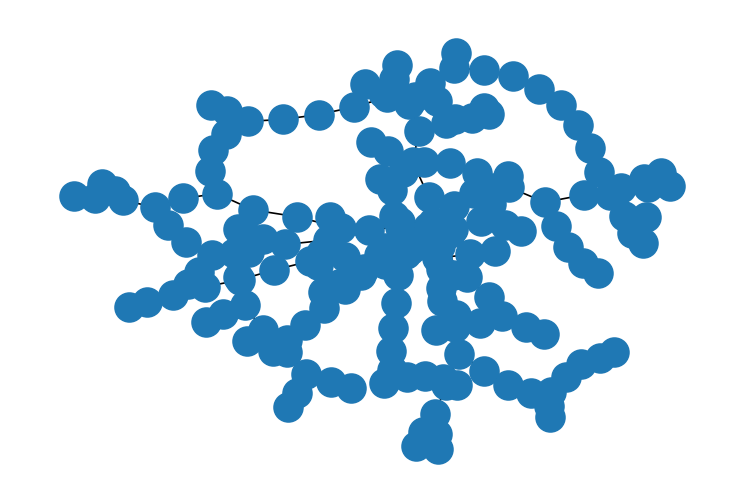

In [41]:
networkx.draw(explorer.graph)

In [42]:
def adjacency_matrix_from_graph(graph):
    """Transform connectivity information in a graph into an adjacency matrix"""

    matrix = np.zeros(
        (graph.number_of_nodes(), graph.number_of_nodes()),
        dtype=int
        )

    for i, j in graph.edges:
        matrix[i, j] = matrix[j, i] = 1

    return matrix

In [43]:
adj_matrix = adjacency_matrix_from_graph(explorer.graph)

In [44]:
adj_matrix.shape

(185, 185)

In [45]:
adj_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [46]:
# Check if everthing is correct
for node, data in explorer.graph.nodes(data=True):
    assert maze.maze[data["cell"]] == 0

    i = node

    for edge in explorer.graph.edges(node):
        j = edge[1]

        neighbour = explorer.graph.nodes[j]["cell"]
        assert maze.maze[neighbour] == 0

        assert adj_matrix[i, j] == adj_matrix[j, i] == 1

assert np.count_nonzero(adj_matrix) == 2 * explorer.graph.number_of_edges()

### Dijkstra

In [100]:
start = explorer.energy.pick_random_accessible_cell()
end = explorer.energy.pick_random_accessible_cell()

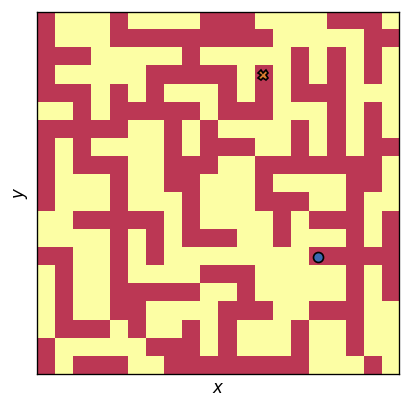

In [106]:
plt.close("all")
fig, ax = plt.subplots()
im = ax.imshow(
    maze.maze, vmin=-1, vmax=1,
    cmap=mpl.cm.inferno,
)
ax.set(**{
    "xlabel": "$x$",
    "ylabel": "$y$",
    "xticks": (),
    "yticks": (),
})

ax.plot(start[1], start[0], marker="o", markeredgecolor="k")
ax.plot(end[1], end[0], marker="X", markeredgecolor="k")
plt.show()

In [102]:
path = explorer.explore_dijkstra(start, end)

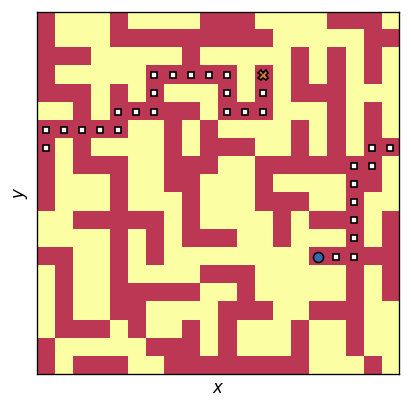

In [107]:
plt.close("all")
fig, ax = plt.subplots()
im = ax.imshow(
    maze.maze, vmin=-1, vmax=1,
    cmap=mpl.cm.inferno,
)
ax.set(**{
    "xlabel": "$x$",
    "ylabel": "$y$",
    "xticks": (),
    "yticks": (),
})

for cell_id in path:
    cell = explorer.graph.nodes[cell_id]["cell"]
    ax.plot(
        cell[1], cell[0],
        marker="s", markerfacecolor="w", markeredgecolor="k",
        markersize=4
        )

ax.plot(start[1], start[0], marker="o", markeredgecolor="k")
ax.plot(end[1], end[0], marker="X", markeredgecolor="k")
plt.show()

## Scratch

In [ ]:
matrix = np.zeros((3, 3))
for i in np.ndindex(matrix.shape):
    print(i)